<a href="https://colab.research.google.com/github/Vinyurchin/Act-18-Funciones/blob/main/emotion_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: pip install tensorflow==2.8.0
# pip install keras==2.8.0

!pip install protobuf==3.19.3
!pip install tensorflow==2.8.0
!pip install keras==2.8.0


In [ ]:
import pandas as pd
import numpy as np
import os
import PIL
import seaborn as sns
import pickle
from PIL import *
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
from IPython.display import display
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow

In [ ]:
# Cargar los puntos faciales clave
keyfacial_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Emotion AI Dataset/data.csv')

In [ ]:
keyfacial_df['Image'].shape

(2140,)

In [ ]:
# Comprobar si hay valores nulos en el DataSet
keyfacial_df.isnull(). sum()

,0
left_eye_center_x,0
left_eye_center_y,0
right_eye_center_x,0
right_eye_center_y,0
left_eye_inner_corner_x,0
left_eye_inner_corner_y,0
left_eye_outer_corner_x,0
left_eye_outer_corner_y,0
right_eye_inner_corner_x,0
right_eye_inner_corner_y,0


In [ ]:
# Dado que los valores para la imagen se dan como cadenas separadas por los espacios
# separamos los valores usando '' como separado.
# Luego convertimos esto en una matriz numérica usando np.fromstring y la convertimos
# en una matriz unidimensional 1D obtenida de una matriz 2D de forma 96*96
keyfacial_df['Image'] = keyfacial_df['Image'].apply(lambda x: np.fromstring(x, dtype = int, sep = ' ').reshape(96, 96))

In [ ]:
# Obtain the shape of the image
keyfacial_df['Image'][0].shape

(96, 96)

Mini reto # 1

- Obtenga los valores promedio, mínimo y máximo para 'right_eye_center_x'

In [ ]:
keyfacial_df.describe()

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
count,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,...,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000,2140.000000
mean,66.221549,36.842274,29.640269,37.063815,59.272128,37.856014,73.412473,37.640110,36.603107,37.920852,...,47.952141,57.253926,63.419076,75.887660,32.967365,76.134065,48.081325,72.681125,48.149654,82.630412
std,2.087683,2.294027,2.051575,2.234334,2.005631,2.034500,2.701639,2.684162,1.822784,2.009505,...,3.276053,4.528635,3.650131,4.438565,3.595103,4.259514,2.723274,5.108675,3.032389,4.813557
min,47.835757,23.832996,18.922611,24.773072,41.779381,27.190098,52.947144,26.250023,24.112624,26.250023,...,24.472590,41.558400,43.869480,57.023258,9.778137,56.690208,32.260312,56.719043,33.047605,57.232296
25%,65.046300,35.468842,28.472224,35.818377,58.113054,36.607950,71.741978,36.102409,35.495730,36.766783,...,46.495330,54.466000,61.341291,72.874263,30.879288,73.280038,46.580004,69.271669,46.492000,79.417480
50%,66.129065,36.913319,29.655440,37.048085,59.327154,37.845220,73.240045,37.624207,36.620735,37.920336,...,47.900511,57.638582,63.199057,75.682465,33.034022,75.941985,47.939031,72.395978,47.980854,82.388899
75%,67.332093,38.286438,30.858673,38.333884,60.521492,39.195431,74.978684,39.308331,37.665280,39.143921,...,49.260657,60.303524,65.302398,78.774969,35.063575,78.884031,49.290000,75.840286,49.551936,85.697976
max,78.013082,46.132421,42.495172,45.980981,69.023030,47.190316,87.032252,49.653825,47.293746,44.887301,...,65.279654,75.992731,84.767123,94.673637,50.973348,93.443176,61.804506,93.916338,62.438095,95.808983


## 3.- Visuaización de imágenes.

<ipython-input-10-f3c87e35087f>:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1],keyfacial_df.loc[i][j], 'rx')


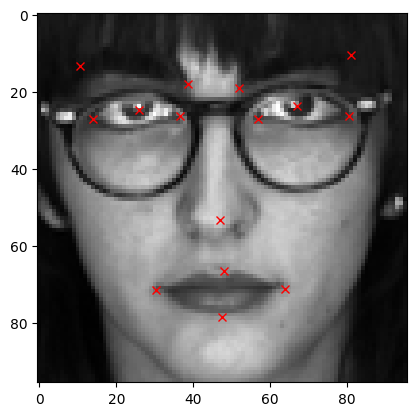

In [ ]:
# Representamos una imagen aleatoria del conjunto de datos junto con puntos clave faciales.
# Los datos de la imagen se obtienen por ['Image'] y se representan usando plt.imshow
# 15 coordenadas X e y para la imagen correspondiente
# Dado que las coordenadas x están en columnas pares como 0,2,4, .. y las coordenadas y están en columnas impares como 1,3,5 ...
# Accedemos a su valor usando el comando .loc, que obtiene los valores de las
# coordenadas de la imagen en función de la columna a la que se refiere

i = np.random.randint(1, len(keyfacial_df))
plt.imshow(keyfacial_df['Image'][i], cmap = 'gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df.loc[i][j-1],keyfacial_df.loc[i][j], 'rx')

<ipython-input-11-8a195110d678>:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')


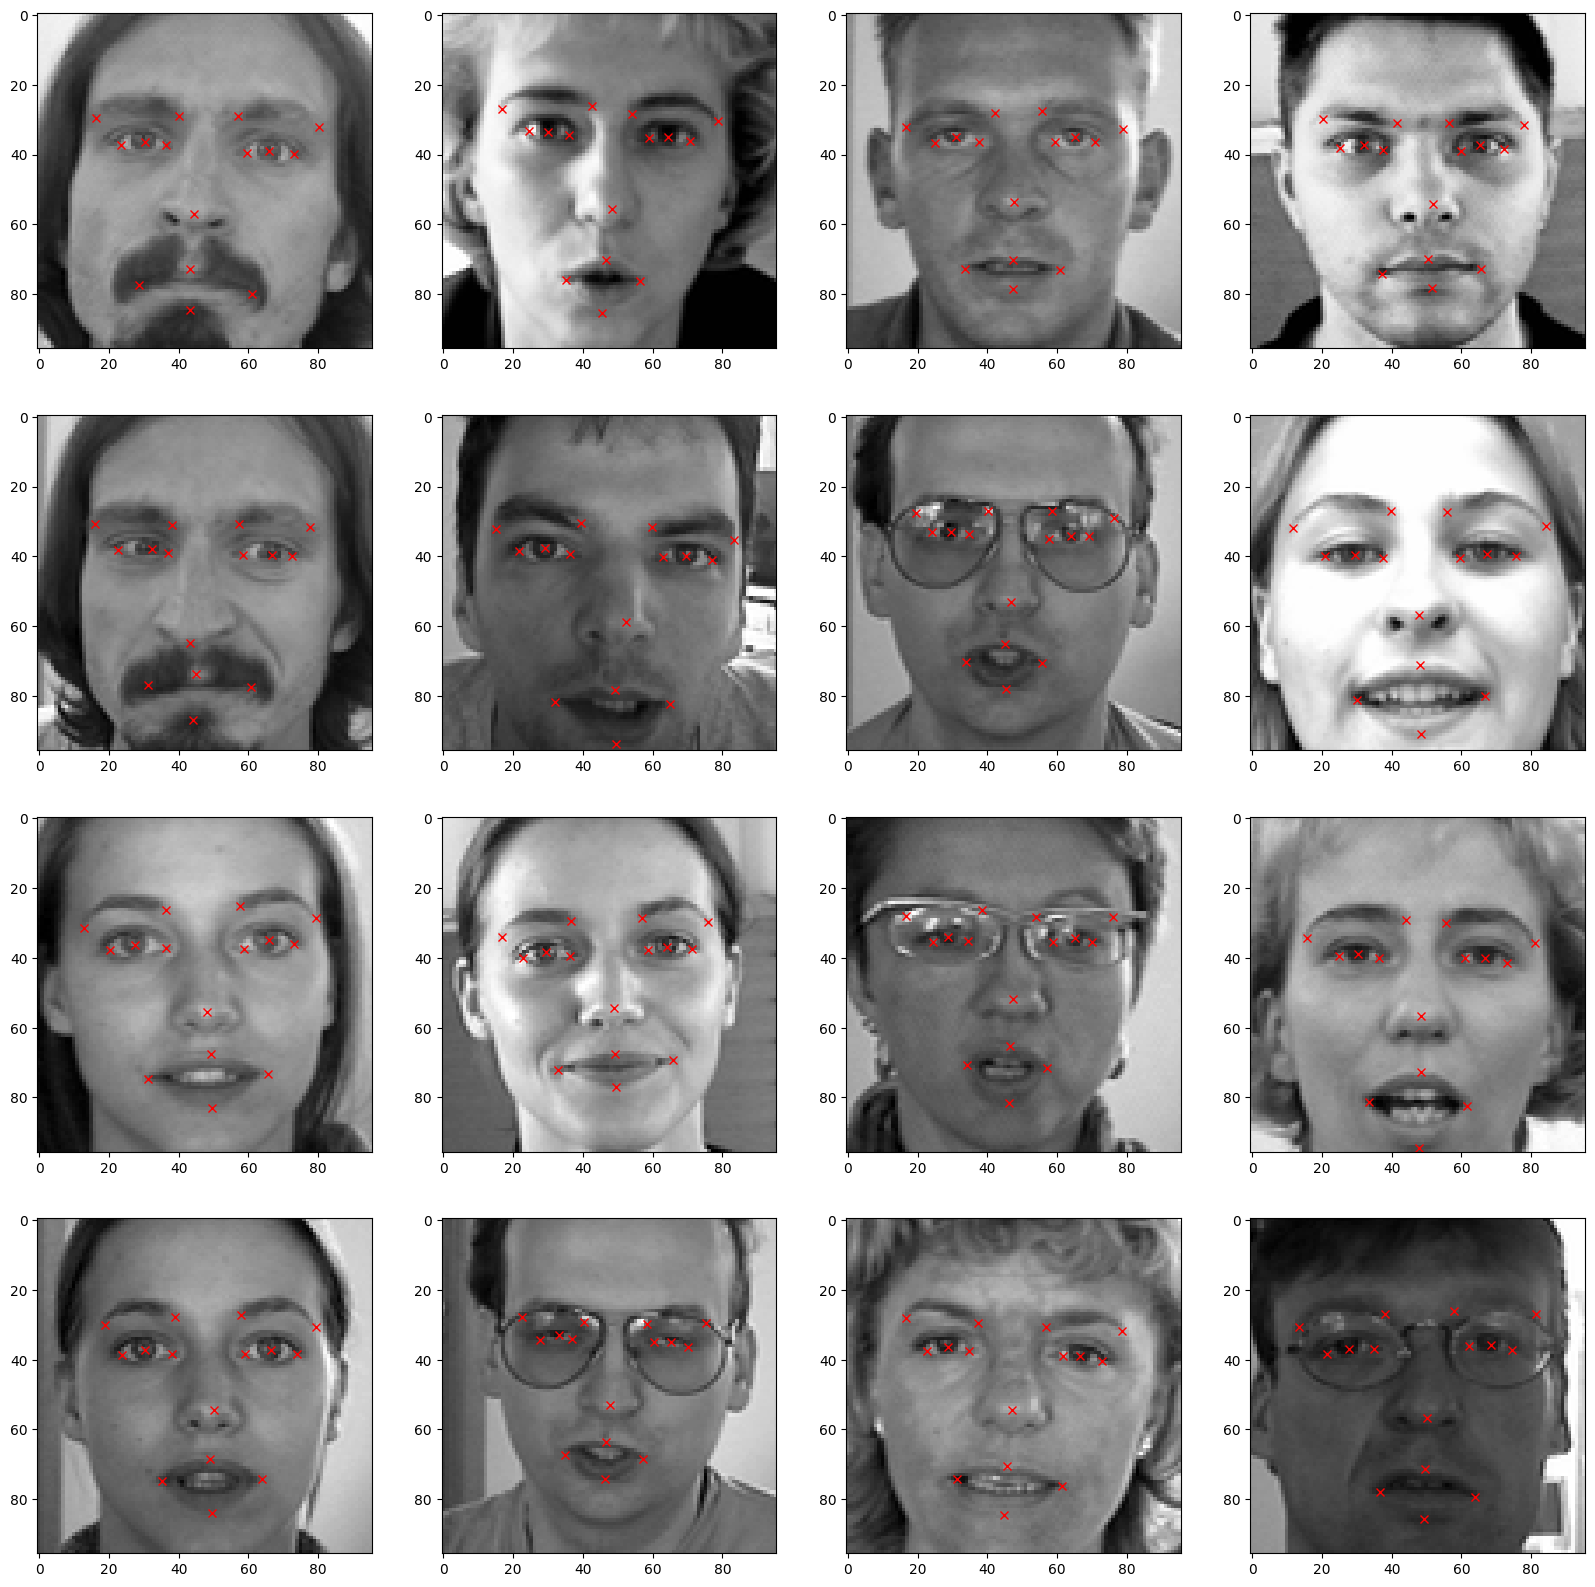

In [ ]:
# Veamos más imágenes en formato matricial
fig = plt.figure(figsize=(20,20))

for i in range(16):
  ax = fig.add_subplot(4, 4, i + 1)
  image = plt.imshow(keyfacial_df['Image'][i],cmap = "gray")
  for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[i][j-1], keyfacial_df.loc[i][j], 'rx')

##MINI RETO #2

Realiza una verificacion adicional en los datos visualizando aleatoriamente 64 nuevas imágenes junto con sus puntos claves correspondientes

<ipython-input-12-d354ef46b856>:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')


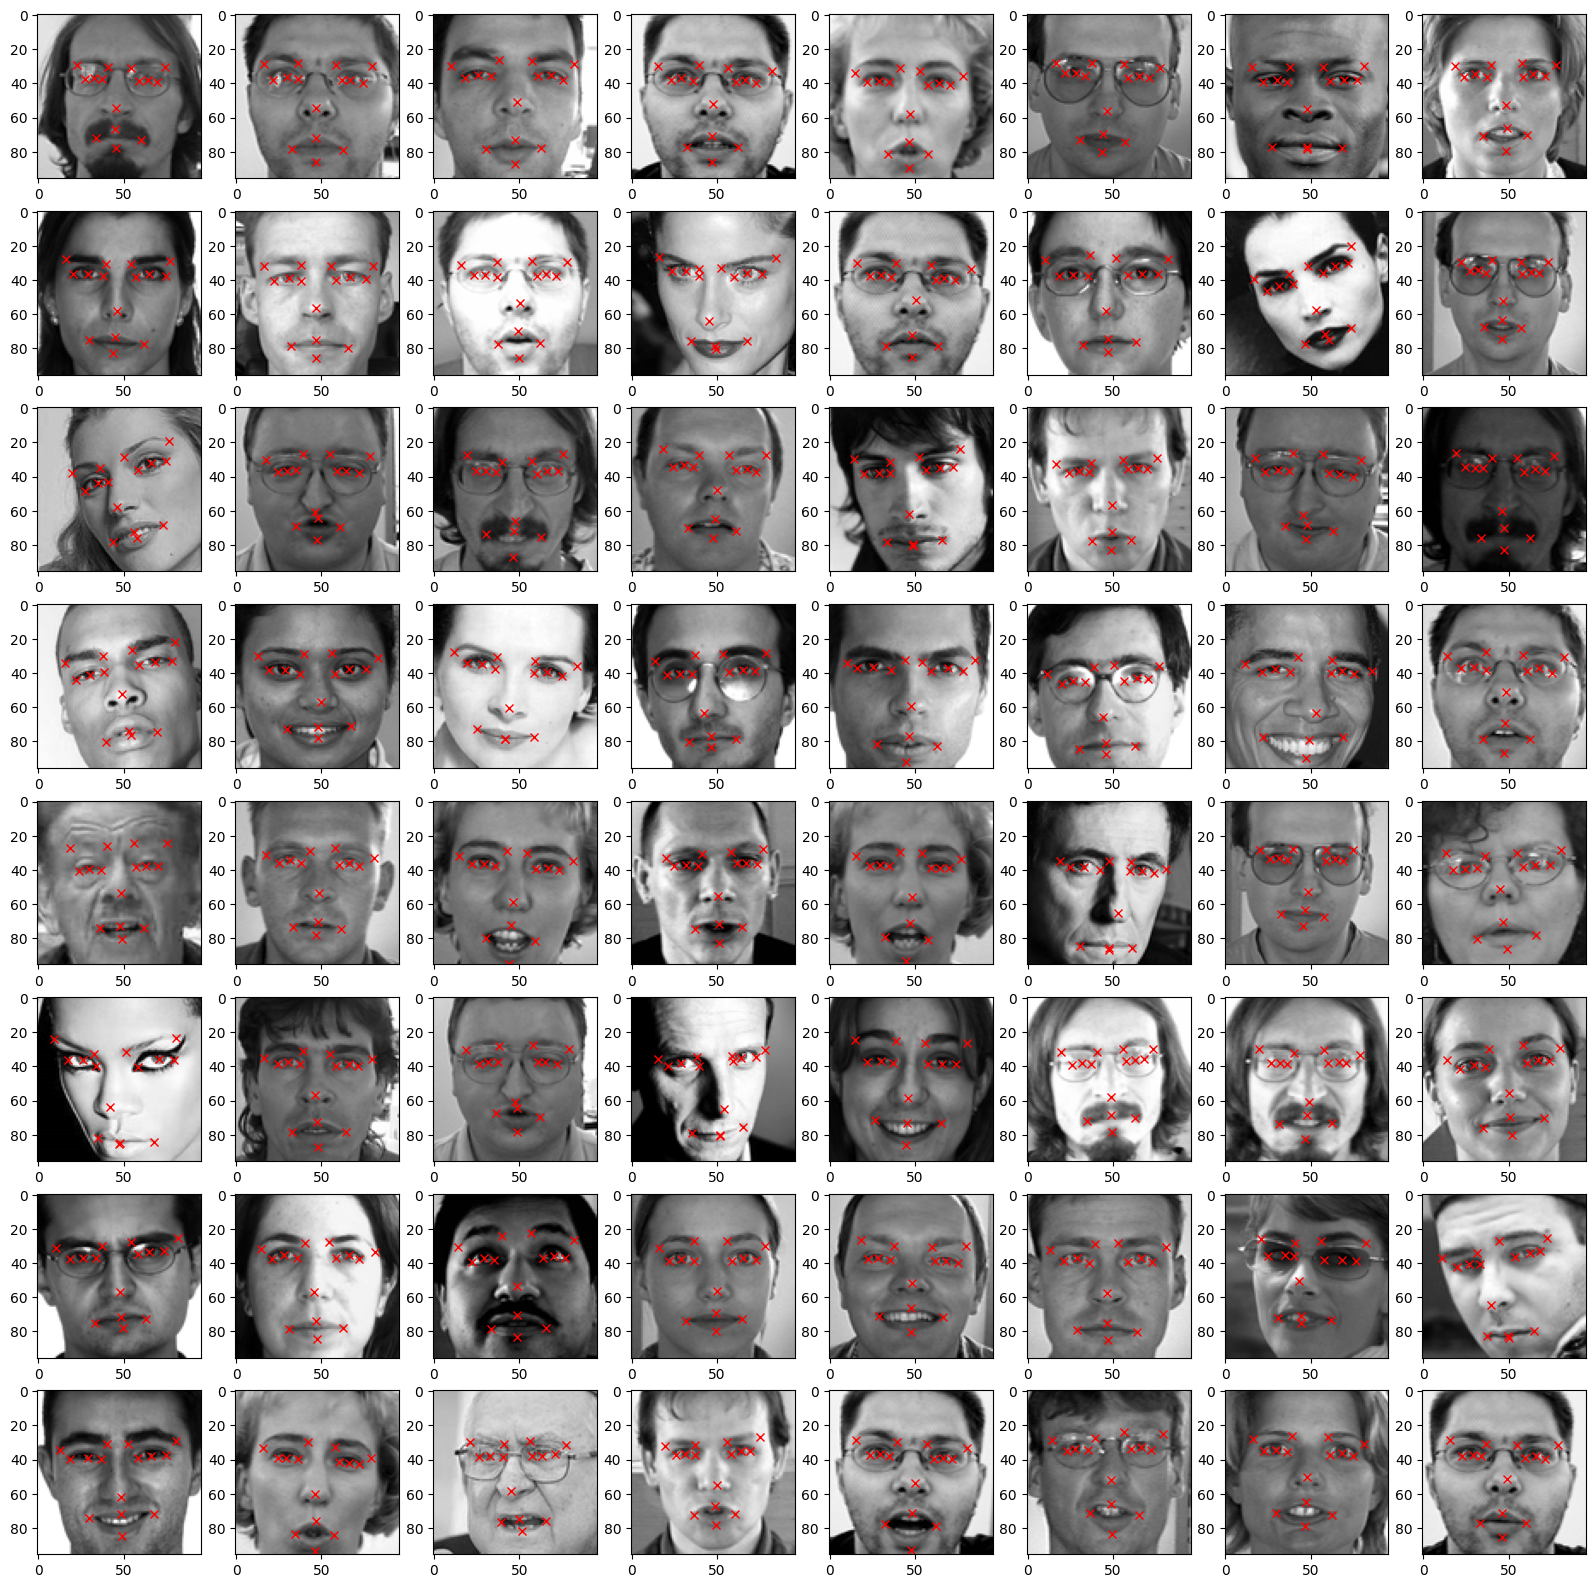

In [ ]:
import random
fig = plt.figure(figsize=(20,20))

for i in range(64):
  k = random.randint(1, len(keyfacial_df))
  ax = fig.add_subplot(8, 8, i + 1)
  image = plt.imshow(keyfacial_df['Image'][k], cmap = 'gray')
  for j in range(1,31,2):
    plt.plot(keyfacial_df.loc[k][j-1], keyfacial_df.loc[k][j], 'rx')

# Tarea #4: Aumentación de las imágenes

In [ ]:
# Creamos una copia del DataFrame
import copy
keyfacial_df_copy = copy.copy(keyfacial_df)

In [ ]:
# Obtenemos las columnas del DataFrame

columns = keyfacial_df_copy.columns[:-1]
columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y'],
      dtype='object')

In [ ]:
# Horizontal Flip - damos la vuelta a las imágenes en torno al eje y
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 1))

# Dado qye estamos volteando horizontalmente, los valores de la coordenada y seían los mismos, solo cambiarían los valores
# de la coordenada x, todo lo que tenemos que hacer es restar nuestros valores iniciales de la coordenada x del ancho de la imagen (96)
for i in range(len(columns)):
  if i%2 == 0:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

<ipython-input-16-c4beddea613d>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


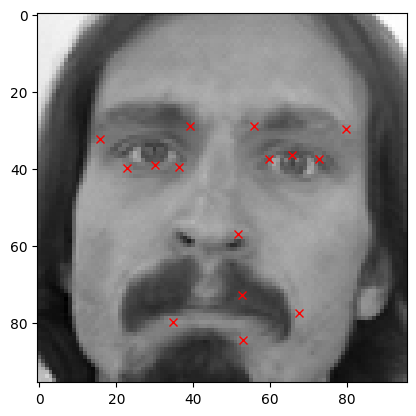

In [ ]:
# Mostramos la imagen original
plt.imshow(keyfacial_df['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

<ipython-input-17-24b4c4441d0a>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


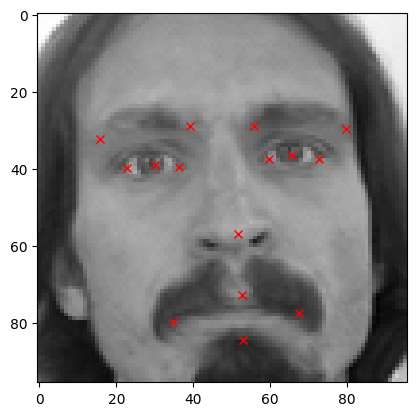

In [ ]:
# Mostramos la imagen girada horizontalmente
plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

In [ ]:
# Concatenamos el DataSet original con el dataFrame aumentado
augmented_df = np.concatenate((keyfacial_df, keyfacial_df_copy))

In [ ]:
augmented_df.shape

(4280, 31)

In [ ]:
# Aumentar aleatoriamente el brillo de las imágenes
# multiplicamos los valores de los píxeles por valores aleatorios entre
# 1,5 y 2 para aumentar el brillo de la imagen
# recortamos el valor entre 0  y 255

import random

keyfacial_df_copy = copy.copy(keyfacial_df)
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x:np.clip(random.uniform(
    1.5, 2)* x, 0.0, 255.0))
augmented_df = np.concatenate((augmented_df, keyfacial_df_copy))
augmented_df.shape

(6420, 31)

<ipython-input-22-7ffdf344d423>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


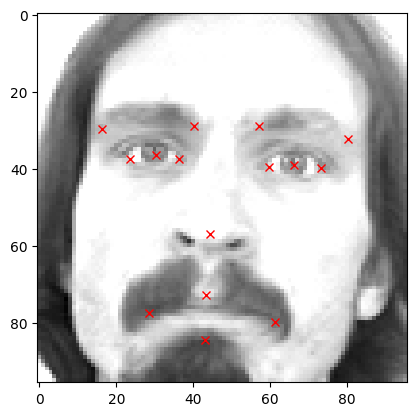

In [ ]:
# Mostramos la imagen con brillo aumentado

plt.imshow(keyfacial_df_copy['Image'][0], cmap = 'gray')
for j in range (1, 31, 2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')

# MINI RETO #3

In [ ]:
keyfacial_df_copy = copy.copy(keyfacial_df)

In [ ]:
keyfacial_df_copy['Image'] = keyfacial_df_copy['Image'].apply(lambda x: np.flip(x, axis = 0))

for i in range(len(columns)):
  if i%2 == 1:
    keyfacial_df_copy[columns[i]] = keyfacial_df_copy[columns[i]].apply(lambda x: 96. - float(x))

# MINI RETO #4

Haz una comprobación adicional y visualiza las imágenes

<ipython-input-29-1549f4e39a53>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')


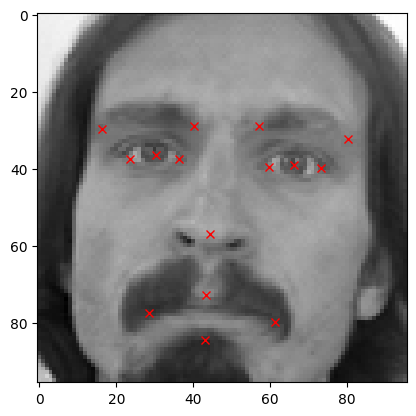

In [ ]:
plt.imshow(keyfacial_df_copy['Image'][0], cmap='gray')
for j in range(1, 31, 2):
  plt.plot(keyfacial_df_copy.loc[0][j-1], keyfacial_df_copy.loc[0][j], 'rx')